# RFM Segmentasyonu / Analizi
RFM müşterileri segmentlemek, mevcut durumu gözlemlemek amacıyla uygulanan bir metoddur.

• Recency: Genel anlamda, ‘müşterinin son alışverişinden bugüne kadar geçen zaman’ olarak tanımlanabilir. Sadece alışveriş olarak değil, müşterinin websitemizi en son ne zaman ziyaret ettiği, en son call center arama tarihinden bugüne kadar geçen zaman da olabilir. Müşteri bazında (Bugünün tarihi-Son ziyaret tarihi) olarak hesaplanır.

• Frequency: Müşterinin alışveriş sıklığı olarak tanımlanabilir. Yine, ziyaret sıklığı gibi farklı tanımlamalar da kabul edilebilir. İhtiyaca göre bu işlem farklılaşır. Genellikle ham sipariş datası üzerinde çalışırken, sipariş numarası kişi bazında saydırılır.

• Monetary: Müşterinin ne kadar harcama yaptığıdır. Müşteri bazında getirdiği ciro toplanır.

Bazı çalışmalarda, RFM'e yeni metrikler eklendiğini görüyoruz.

• Tenure: Bir müşterinin sitemizle/ şirketimizle ilk temasından bu yana geçen zamandır. İlk üye olduğu tarih, ilk alışveriş yaptığı tarih olarak kabul edilebilir.

In [166]:
#Ortamımızı belirliyoruz
import os 
os.getcwd()
path='F:\3. Sınıf\Makine Öğrenmesine Giriş\Sena_Özkara_1911404013_Makine_Öğrenmesi_Vize_Ödevi'


#Kütüphaneleri yüklüyoruz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#Datayı yüklüyoruz
data = pd.read_csv('data2.csv',encoding = 'unicode_escape')

#Toplam harcamayı sütun olarak ekliyoruz
data['TotalPrice'] = data['Price']*data['Quantity']

#Sipariş tarihinin veri tipini değiştiriyoruz
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

#Bugünü/ analiz tarihini değişken olarak belirliyoruz.
#Veri setinin tarihi 2009-2010-2011 yıllarını kapsadığı için ben 2012'yi son gün olarak verdim.
today = dt.datetime(2012,1,1)
print(today)

#0'dan büyük değerleri alıyoruz.
data = data[data['Quantity'] > 0]
data = data[data['TotalPrice'] > 0]

2012-01-01 00:00:00


In [162]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [163]:

#Recency ve Monetary değerleri buluyoruz.
data_x = data.groupby('Customer ID').agg({'TotalPrice': lambda x: x.sum(),
                                        'InvoiceDate': lambda x: (today - x.max()).days})
#Data StockCode bazında olduğu için, InvoiceNo'yu unique hale getiriyoruz.
data_y = data.groupby(['Customer ID','Invoice']).agg({'TotalPrice': lambda x: x.sum()})

#Saydırdığımızda InvoiceNo unique halde gelmiş oluyor.
data_z = data_y.groupby('Customer ID').agg({'TotalPrice': lambda x: len(x)})

#RFM tablosuna ulaşmış oluyoruz.
rfm_table= pd.merge(data_x,data_z, on='Customer ID')

#Sütun isimlerini belirliyoruz
rfm_table.rename(columns= {'InvoiceDate': 'Recency',
                          'TotalPrice_y': 'Frequency',
                          'TotalPrice_x': 'Monetary'}, inplace= True)

In [164]:
rfm_table.head()


,Monetary,Recency,Frequency
Customer ID,,,
12346.0,372.86,551,11.0
12347.0,1323.32,389,2.0
12348.0,222.16,460,1.0
12349.0,2671.14,429,3.0
12351.0,300.93,397,1.0


Yukarıdaki tabloyu inceleyecek olursak customer ID'si 12346.0 olan müşterimiz bizden  372.86 tl'lik alışveriş yapmış(monetary değeri).En son 551 gün önce neredeyse 2 yıl önce alışveriş yapmış(recency değeri) vebizden 11 kez alışveriş yapmış.(frequency değeri)Biz RFM değerlerini hesaplayıp tablo çıkarmakla müşteninin genel durumunu çıkarmış oluyoruz.

In [165]:
#Frequency bulma
def RScore(x,p,d):
    if x <= d[p][0.20]:
        return 0
    elif x <= d[p][0.40]:
        return 1
    elif x <= d[p][0.60]: 
        return 2
    elif x <= d[p][0.80]:
        return 3
    else:
        return 4

quantiles = rfm_table.quantile(q=[0.20,0.40,0.60,0.80])
quantiles = quantiles.to_dict()
rfm_table['Freq_Tile'] = rfm_table['Frequency'].apply(RScore, args=('Frequency',quantiles,))

#Recency bulma
rfm_table = rfm_table.sort_values('Recency',ascending=True)
rfm_table['Rec_Tile'] = pd.qcut(rfm_table['Recency'],5,labels=False)

#Monetary bulma
#rfm_table.sort_values('Monetary',ascending=False)
rfm_table['Mone_Tile'] = pd.qcut(rfm_table['Monetary'],5,labels=False)

#'Sıfır' değeri yer almasın istiyorsak, bulduğumuz değerleri 1 arttırıyoruz
rfm_table['Rec_Tile'] = rfm_table['Rec_Tile'] + 1
rfm_table['Freq_Tile'] = rfm_table['Freq_Tile'] + 1
rfm_table['Mone_Tile'] = rfm_table['Mone_Tile'] + 1

#Bulduğumuz değerleri birleştirip tek bir skor elde ediyoruz
rfm_table['RFM Score'] = rfm_table['Rec_Tile'].map(str) + rfm_table['Freq_Tile'].map(str) + rfm_table['Mone_Tile'].map(str)
rfm_table.head()

,Monetary,Recency,Frequency,Freq_Tile,Rec_Tile,Mone_Tile,RFM Score
Customer ID,,,,,,,
14932.0,666.13,387,2.0,2,1,3,123
14667.0,12685.94,387,31.0,5,1,5,155
17097.0,386.03,387,2.0,2,1,2,122
15288.0,1576.61,387,6.0,4,1,4,144
17950.0,950.61,387,6.0,4,1,3,143


In [136]:
#Değerlerin içeriklerini inceliyoruz.
rfm_table.groupby('RFM Score').agg({
'Recency': ['mean','min','max','count'],
'Frequency': ['mean','min','max','count'],
'Monetary': ['mean','min','max','count'] }).round(1).head()

Recency                 Frequency                 Monetary          \
             mean  min  max count      mean  min  max count     mean     min   
RFM Score                                                                      
111         395.3  388  401    44       1.0  1.0  1.0    44    143.8    11.0   
112         394.7  387  401    35       1.0  1.0  1.0    35    341.9   255.0   
113         394.5  388  400     6       1.0  1.0  1.0     6    781.4   590.0   
114         397.3  394  401     3       1.0  1.0  1.0     3   1367.9  1056.6   
115         396.0  396  396     1       1.0  1.0  1.0     1   2945.4  2945.4   

                         
              max count  
RFM Score                
111         247.4    44  
112         487.8    35  
113         949.8     6  
114        1938.4     3  
115        2945.4     1

In [137]:
rfm_table.groupby('RFM Score').size().sort_values(ascending=False)[:10]

RFM Score
511    338
155    330
512    184
411    154
255    145
311    120
144    107
244    100
412     98
312     98
dtype: int64

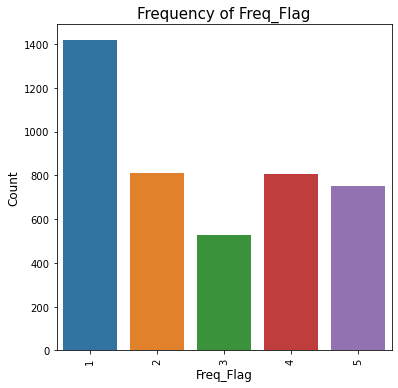

In [138]:
plt.figure(figsize=(6,6))
sns.countplot(x='Freq_Tile', data=rfm_table)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Freq_Flag', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Frequency of Freq_Flag', fontsize=15)
plt.show()

# K-Means Segmentasyonu
Gözetimsiz öğrenme algoritmalarından biridir. Amaç: Datayı belirli özelliklerine göre ayırıp, karakteristik özelliklerini çıkartmak. Noktalar arası uzaklık toplamını minimize etmek. Kümeler arası uzaklığı maksimize etmek.

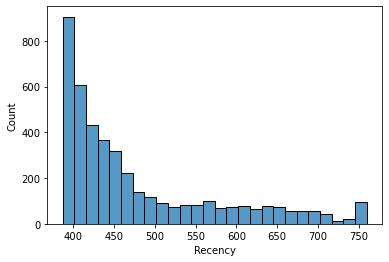

In [139]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.histplot(rfm_table['Recency'])
plt.show()

<AxesSubplot:xlabel='Frequency', ylabel='Count'>

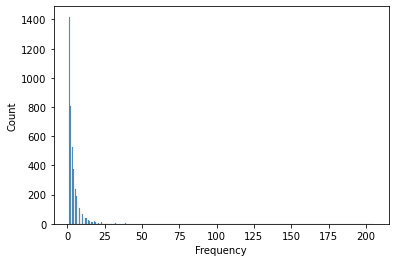

In [140]:
sns.histplot(rfm_table['Frequency'])

<AxesSubplot:xlabel='Monetary', ylabel='Count'>

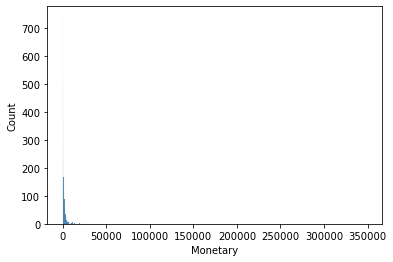

In [141]:
sns.histplot(rfm_table['Monetary'])

In [142]:
rfm_table.head()

,Monetary,Recency,Frequency,Freq_Tile,Rec_Tile,Mone_Tile,RFM Score
Customer ID,,,,,,,
14932.0,666.13,387,2.0,2,1,3,123
14667.0,12685.94,387,31.0,5,1,5,155
17097.0,386.03,387,2.0,2,1,2,122
15288.0,1576.61,387,6.0,4,1,4,144
17950.0,950.61,387,6.0,4,1,3,143


In [143]:
clus = rfm_table[['Monetary','Recency','Frequency']]


In [144]:
clus.head()

,Monetary,Recency,Frequency
Customer ID,,,
14932.0,666.13,387,2.0
14667.0,12685.94,387,31.0
17097.0,386.03,387,2.0
15288.0,1576.61,387,6.0
17950.0,950.61,387,6.0


In [145]:
clusterdata=clus.iloc[:,0:4]
clusterdata.head()

,Monetary,Recency,Frequency
Customer ID,,,
14932.0,666.13,387,2.0
14667.0,12685.94,387,31.0
17097.0,386.03,387,2.0
15288.0,1576.61,387,6.0
17950.0,950.61,387,6.0


In [146]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(clus)
data_scaled2 = pd.DataFrame(x_scaled)

In [147]:
data_scaled2.head()

,0,1,2
0,0.001899,0.0,0.004902
1,0.036324,0.0,0.147059
2,0.001097,0.0,0.004902
3,0.004507,0.0,0.024510
4,0.002714,0.0,0.024510


In [148]:
data_scaled2.describe()

,0,1,2
count,4312.000000,4312.000000,4312.000000
mean,0.005858,0.241749,0.016940
std,0.025531,0.259682,0.040050
min,0.000000,0.000000,0.000000
25%,0.000874,0.045576,0.000000
50%,0.002014,0.139410,0.004902
75%,0.004927,0.361930,0.019608
max,1.000000,1.000000,1.000000


In [149]:
?KMeans

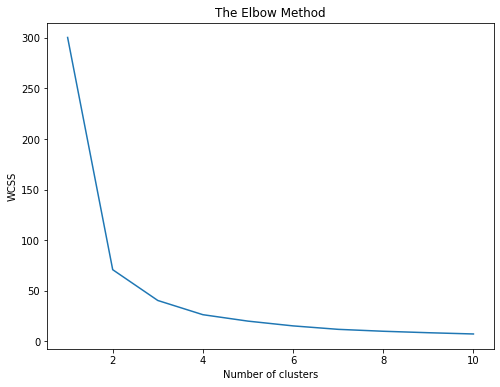

In [150]:
plt.figure(figsize=(8,6))
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',n_init=10, max_iter = 300)
    kmeans.fit(data_scaled2)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [151]:
from sklearn.metrics import silhouette_score
inertia_list=[]
silhouette_score_list=[]
for i in range (2,10):
    #kmeans = KMeans(init='k-means++', n_clusters=i, n_init=10, max_iter = 300)
    kmeans.fit(data_scaled2)
    silhouette_score_list.append(silhouette_score(data_scaled2,kmeans.labels_))
    print(silhouette_score_list)

[0.4795643854820798]
[0.4795643854820798, 0.48374395316294405]
[0.4795643854820798, 0.48374395316294405, 0.49190715379592426]
[0.4795643854820798, 0.48374395316294405, 0.49190715379592426, 0.48377995579424693]
[0.4795643854820798, 0.48374395316294405, 0.49190715379592426, 0.48377995579424693, 0.49136348492596593]
[0.4795643854820798, 0.48374395316294405, 0.49190715379592426, 0.48377995579424693, 0.49136348492596593, 0.49154966464556893]
[0.4795643854820798, 0.48374395316294405, 0.49190715379592426, 0.48377995579424693, 0.49136348492596593, 0.49154966464556893, 0.48182631150667365]
[0.4795643854820798, 0.48374395316294405, 0.49190715379592426, 0.48377995579424693, 0.49136348492596593, 0.49154966464556893, 0.48182631150667365, 0.4845372038311375]


In [152]:
# k means using 3 clusters and k-means++ initialization
kmeans = KMeans(n_clusters = 4, init='k-means++', n_init =10,max_iter = 300)
kmeans.fit(data_scaled2)
pred = kmeans.predict(data_scaled2)

In [153]:
pred = kmeans.predict(data_scaled2)

In [154]:
d_frame = pd.DataFrame(clus)
d_frame['cluster'] = pred
d_frame['cluster'].value_counts()

3    2057
0    1151
2     630
1     474
Name: cluster, dtype: int64

In [155]:
d_frame.head()

,Monetary,Recency,Frequency,cluster
Customer ID,,,,
14932.0,666.13,387,2.0,3
14667.0,12685.94,387,31.0,3
17097.0,386.03,387,2.0,3
15288.0,1576.61,387,6.0,3
17950.0,950.61,387,6.0,3


In [156]:
d_frame.groupby('cluster').mean()

,Monetary,Recency,Frequency
cluster,,,
0,1233.741964,464.344049,3.105995
1,544.810281,690.476793,1.369198
2,720.482303,573.241270,2.063492
3,3257.084273,405.775401,6.654837


Bu tabloyu yorumlayacak olursak 
    0. clusterdaki kişilerin monetary değerleri ortalama 1232, recency değerleri 464 ve frequency değerleri 3. Yani harcadıkları miktar güzel ama bir yılı geçmiş bir süredir gelmemişler alışveriş yapmamışlar diğer clusterlara bakarsak onlardan daha sık alışveriş yapmışlar. 2.clusterdan sonraki en iyi cluster denilebilir.
    1. clusterdaki kişilerin monetary değerleri ortalama 528, recency değerleri 692 ve frequency değerleri 1. Yani harcadıkları miktar kötü ve bir yılı geçmiş ve neredeyse iki yıla yaklaşmış süredir gelmemişler alışveriş yapmamışlar diğer clusterlara bakarsak onlardan daha az alışveriş yapmışlar neredeyse bir kere ve bu kayıp müşteri gibi oluyor bu müşretileri geri kazanmak bizim için daha maliyetli bir işlem.
     2. clusterdaki kişilerin monetary değerleri ortalama 3257, recency değerleri 405 ve frequency değerleri 6. Yani harcadıkları miktar diğerlerine göre çok iyi ama bir yılı biraz geçmiş süredir gelmemişler alışveriş yapmamışlar diğer clusterlara bakarsak onlardan daha çok  alışveriş yapmışlar hatta en fazla alışveriş sıklığı bu clusterda.Bu müşreti gurubu bizim için VİP,Loyal müşteri olarak tanımlayabileceğimiz grupta yer alıyor.Bu müşterilere özel kampanyalar (kargo bedava veya hediye kampanyaları vs.)
yaparsak çok çabuk geri kazanabilir ve alışveriş sıklıklarını arttırabiliriz.
    3. clusterdaki kişilerin monetary değerleri ortalama 728, recency değerleri 574 ve frequency değerleri 2. Yani harcadıkları miktar kötü ve bir yılı geçmiş süredir gelmemişler alışveriş yapmamışlar diğer clusterlara bakarsak onlardan daha az alışveriş yapmışlar 2 kere. Diğer clusterlara bakarsak 3. en iyi olarak tanımlayabiliriz ama genel olarak kötü bir cluster. 


# Association Rules - Birliktelik Analizi# 

In [82]:
!pip install mlxtend

In [83]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [84]:
#veriyi küçültmek için United Kingdom'daki siparişleri aldık
data_apriori = data[data['Country']=='United Kingdom']

In [85]:
data_apr = data_apriori.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('Invoice')

In [86]:
data_apr.head()

Description,DOORMAT UNION JACK GUNS AND ROSES,3 STRIPEY MICE FELTCRAFT,4 PURPLE FLOCK DINNER CANDLES,ANIMAL STICKERS,BLACK PIRATE TREASURE CHEST,BROWN PIRATE TREASURE CHEST,Bank Charges,CAMPHOR WOOD PORTOBELLO MUSHROOM,CHERRY BLOSSOM DECORATIVE FLASK,FAIRY CAKE CANDLES,...,ZINC HEART LATTICE CHARGER LARGE,ZINC HEART LATTICE CHARGER SMALL,ZINC HEART LATTICE DOUBLE PLANTER,ZINC HEART LATTICE PLANTER BOWL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC METAL HEART DECORATION,ZINC POLICE BOX LANTERN,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK
Invoice,,,,,,,,,,,,,,,,,,,,,
489434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
def num(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_new = data_apr.applymap(num)

In [88]:
basket_new.head()

Description,DOORMAT UNION JACK GUNS AND ROSES,3 STRIPEY MICE FELTCRAFT,4 PURPLE FLOCK DINNER CANDLES,ANIMAL STICKERS,BLACK PIRATE TREASURE CHEST,BROWN PIRATE TREASURE CHEST,Bank Charges,CAMPHOR WOOD PORTOBELLO MUSHROOM,CHERRY BLOSSOM DECORATIVE FLASK,FAIRY CAKE CANDLES,...,ZINC HEART LATTICE CHARGER LARGE,ZINC HEART LATTICE CHARGER SMALL,ZINC HEART LATTICE DOUBLE PLANTER,ZINC HEART LATTICE PLANTER BOWL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC METAL HEART DECORATION,ZINC POLICE BOX LANTERN,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK
Invoice,,,,,,,,,,,,,,,,,,,,,
489434,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489435,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489436,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489437,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
489438,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


fpgrowt algoritmasının kullanımı yapılışı daha güncel ve hızlı

In [89]:
from mlxtend.frequent_patterns import fpgrowth

rule_fp = fpgrowth(basket_new, min_support=0.02, use_colnames=True)
rule_fp

,support,itemsets
0,0.079985,(STRAWBERRY CERAMIC TRINKET BOX)
1,0.022653,(PINK DOUGHNUT TRINKET POT )
2,0.021824,(SAVE THE PLANET MUG)
3,0.069255,(ASSORTED COLOUR BIRD ORNAMENT)
4,0.067026,(HOME BUILDING BLOCK WORD)
...,...,...
256,0.020424,"(LUNCH BAG RED SPOTTY, LUNCH BAG PINK RETROSPOT)"
257,0.020787,"(WHITE HANGING HEART T-LIGHT HOLDER, REGENCY C..."
258,0.022290,"(WHITE HANGING HEART T-LIGHT HOLDER, HEART OF ..."
259,0.028096,"(HEART OF WICKER LARGE, HEART OF WICKER SMALL)"


Apriori algoritması ile yapılışı

In [90]:
items = apriori(basket_new, min_support=0.02, use_colnames=True)

In [91]:
rule = association_rules(items, metric="lift", min_threshold=1)
rule

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(72 SWEETHEART FAIRY CAKE CASES),(60 TEATIME FAIRY CAKE CASES),0.041626,0.063035,0.022653,0.544209,8.633503,0.020029,2.055692
1,(60 TEATIME FAIRY CAKE CASES),(72 SWEETHEART FAIRY CAKE CASES),0.063035,0.041626,0.022653,0.359375,8.633503,0.020029,1.495999
2,(PACK OF 60 PINK PAISLEY CAKE CASES),(60 TEATIME FAIRY CAKE CASES),0.054067,0.063035,0.027733,0.512943,8.137493,0.024325,1.923730
3,(60 TEATIME FAIRY CAKE CASES),(PACK OF 60 PINK PAISLEY CAKE CASES),0.063035,0.054067,0.027733,0.439967,8.137493,0.024325,1.689067
4,(PACK OF 72 RETRO SPOT CAKE CASES),(60 TEATIME FAIRY CAKE CASES),0.064331,0.063035,0.028355,0.440774,6.992568,0.024300,1.675467
5,(60 TEATIME FAIRY CAKE CASES),(PACK OF 72 RETRO SPOT CAKE CASES),0.063035,0.064331,0.028355,0.449836,6.992568,0.024300,1.700709
6,(WHITE HANGING HEART T-LIGHT HOLDER),(60 TEATIME FAIRY CAKE CASES),0.166088,0.063035,0.020165,0.121411,1.926097,0.009696,1.066443
7,(60 TEATIME FAIRY CAKE CASES),(WHITE HANGING HEART T-LIGHT HOLDER),0.063035,0.166088,0.020165,0.319901,1.926097,0.009696,1.226164
8,(ASSORTED COLOUR BIRD ORNAMENT),(WHITE HANGING HEART T-LIGHT HOLDER),0.069255,0.166088,0.022290,0.321856,1.937868,0.010788,1.229698
9,(WHITE HANGING HEART T-LIGHT HOLDER),(ASSORTED COLOUR BIRD ORNAMENT),0.166088,0.069255,0.022290,0.134207,1.937868,0.010788,1.075020
